In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

In [4]:
from keras import backend as K
from keras.models import Model, Input, load_model
from keras.layers import Dense, Lambda, Activation, Conv1D, MaxPooling1D, Flatten, Reshape
from keras.optimizers import RMSprop, Adam, Adamax, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from keras.layers.merge import add
from keras.utils import to_categorical

Using TensorFlow backend.


In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score as scikit_f1_score

#### Custom Functions

In [7]:
from src.callbacks import PlotCurves
from src.eval_metrics import f1_macro, f1_micro 
from src.load_data import load_data

### Load Data

In [8]:
train_data, valid_data, test_data, metadata = load_data()

### Prepare data

In [9]:
n_tags = 2
batch_size = 32

In [10]:
def get_input(data_, n_tags, is_test=False):
    
    X = np.array([sentence['sentence'].replace('\n', '').strip().lower() 
                  for article in data_ 
                  for sentence in article['sentences']])

    y = np.array([sentence['label'] 
                  for article in data_
                  for sentence in article['sentences']])

    if not is_test:
        y = to_categorical(y, num_classes=n_tags)
    
    return X, y

In [11]:
X_tra, y_tra = get_input(train_data, n_tags, False)
X_val, y_val = get_input(valid_data, n_tags, False)
X_test, y_test = get_input(test_data, n_tags, True)

### Load ELMo

In [12]:
sess = tf.Session()
K.set_session(sess)

In [13]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

## Build Model

In [14]:
def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [ ]:
from keras.models import Sequential
from keras import layers
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    batch_size=10)

In [ ]:
#https://github.com/UKPLab/elmo-bilstm-cnn-crf/blob/master/Keras_ELMo_Tutorial.ipynb
# Simple model for sentence / document classification using CNN + global max pooling
model = Sequential()
model.add(Conv1D(filters=250, kernel_size=3, padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10, batch_size=32)

In [ ]:
# https://www.depends-on-the-definition.com/named-entity-recognition-with-residual-lstm-and-elmo/
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]



input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(None, max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

In [15]:
def build_model_0(n_tags):
    
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
    
    x = Dense(512, kernel_regularizer=l2(0.001))(embedding)
    x = Activation('relu')(x)
    
    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = Activation('relu')(x)
    
    pred = Dense(n_tags, activation='sigmoid')(x)

    return Model(inputs=[input_text], outputs=pred)

In [16]:
def build_model_1(n_tags):
    
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
    
    x = Dense(256, kernel_regularizer=l2(0.001))(embedding)
    x = Activation('relu')(x)
    
    x = Dense(128, kernel_regularizer=l2(0.001))(x)
    x = Activation('relu')(x)
    
    pred = Dense(n_tags, activation='sigmoid')(x)

    return Model(inputs=[input_text], outputs=pred)

In [17]:
def build_model_2(n_tags):
    
    def residual(x):
        x_res = x
        
        x = Dense(256, kernel_regularizer=l2(0.001))(x)
        x = Activation('relu')(x)

        x = add([x, x_res])
        return x
    
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
    
    x = Dense(256, kernel_regularizer=l2(0.001))(embedding)
    x = Activation('relu')(x)
    
    x = residual(x)
    
    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = Activation('relu')(x)
    
    pred = Dense(n_tags, activation='sigmoid')(x)

    return Model(inputs=[input_text], outputs=pred)

In [18]:
def build_model_3(n_tags):
    
    def residual(x):
        x_res = x
        
        x = Dense(256, kernel_regularizer=l2(0.001))(x)
        x = Activation('relu')(x)

        x = Dense(256, kernel_regularizer=l2(0.001))(x)
        x = Activation('relu')(x)

        x = add([x, x_res])
        return x
    
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
    
    x = Dense(256, kernel_regularizer=l2(0.001))(embedding)
    x = Activation('relu')(x)
    
    x = residual(x)

    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = Activation('relu')(dense)
    
    pred = Dense(n_tags, activation='sigmoid')(x)

    return Model(inputs=[input_text], outputs=pred)

In [19]:
def build_model_4(n_tags):
    
    def residual(x):
        x_res = x
        
        x = Dense(512, kernel_regularizer=l2(0.001))(x)
        x = Activation('relu')(x)
        
        x = add([x, x_res])
        return x
    
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
    
    x = Dense(512, kernel_regularizer=l2(0.001))(embedding)
    x = Activation('relu')(x)
    
    x = residual(x)
    
    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = Activation('relu')(x)
    
    pred = Dense(n_tags, activation='sigmoid')(x)

    return Model(inputs=[input_text], outputs=pred)

In [20]:
def build_model_5(n_tags):
    
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
    embedding = Reshape((1024, 1))(embedding)
    
    x = Conv1D(64, 5, padding='same', kernel_regularizer=l2(0.001))(embedding)
    x = Activation('relu')(x)
    x = MaxPooling1D(5)(x)
    
    x = Conv1D(64, 5, padding='same', kernel_regularizer=l2(0.001))(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(5)(x)
    
    x = Flatten()(x)

    x = Dense(512, kernel_regularizer=l2(0.001))(x)
    x = Activation('relu')(x)
    
    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = Activation('relu')(x)
    
    pred = Dense(n_tags, activation='sigmoid')(x)

    return Model(inputs=[input_text], outputs=pred)

In [21]:
def build_model_6(n_tags):
    
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
    embedding = Reshape((1024, 1))(embedding)
    
    x = Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001))(embedding)
    x = Activation('relu')(x)
    x = MaxPooling1D(5)(x)
    
    x = Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001))(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(5)(x)
    
    x = Flatten()(x)

    x = Dense(512, kernel_regularizer=l2(0.001))(x)
    x = Activation('relu')(x)
    
    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = Activation('relu')(x)
    
    pred = Dense(n_tags, activation='sigmoid')(x)

    return Model(inputs=[input_text], outputs=pred)

In [22]:
def build_model_7(n_tags):
    
    def residual(x):
        x_res = x
        
        x = Conv1D(64, 5, padding='same', kernel_regularizer=l2(0.001))(x)
        x = Activation('relu')(x)
        
        x = Conv1D(64, 5, padding='same', kernel_regularizer=l2(0.001))(x)
        x = Activation('relu')(x)
        
        x = add([x, x_res])
        return x
    
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
    embedding = Reshape((1024, 1))(embedding)
    
    x = Conv1D(64, 5, padding='same', kernel_regularizer=l2(0.001))(embedding)
    x = Activation('relu')(x)
    x = MaxPooling1D(5)(x)
    
    x = residual(x)
    x = MaxPooling1D(5)(x)
    
    x = Flatten()(x)

    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = Activation('relu')(x)
    
    pred = Dense(n_tags, activation='sigmoid')(x)

    return Model(inputs=[input_text], outputs=pred)

In [26]:
learningrate=0.01
optimizer = Adam(lr=learningrate)
optimizer_str = 'adam'
loss = 'binary_crossentropy'
metrics = ['acc', f1_macro, f1_micro]

In [27]:
model = build_model_0(n_tags)
model.summary()

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
activation_3 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 514       
Total para

In [28]:
model_name = 'RQ1_test_elmo_model_0' + \
             '_' + optimizer_str +  \
             '_lr_' + str(learningrate) +  \
             '_lrreduction' + \
             '_loss_' + loss

model_dir = './Model/' + model_name.split('model')[0] + 'model/' + model_name
results_file = os.path.join(model_dir, 'model_results_file.txt')

### Train

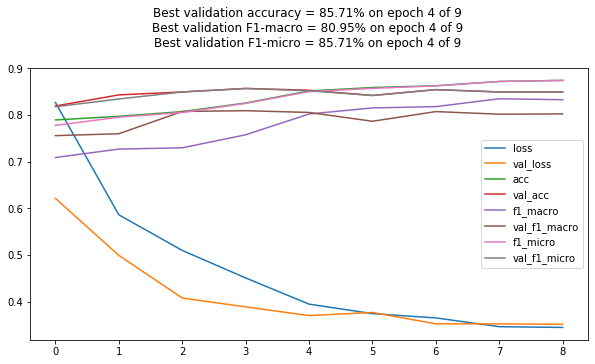

In [29]:
model.fit(X_tra, y_tra, 
          epochs=50, 
          batch_size=batch_size, 
          validation_data=(X_val, y_val), 
          callbacks=[
              PlotCurves(model_name=model_name, model_dir=model_dir, jnote=True),
              ReduceLROnPlateau(monitor='val_f1_macro', patience=3, 
                                factor=0.1, min_lr=0.00001),
              EarlyStopping(monitor='val_f1_macro', min_delta=0, patience=10, mode='max')
          ])

### Load the best Model

In [222]:
model_name

'RQ1_elmo_fnn_model_13_convolution_test_Adam_lr_0.01_lrreduction_loss_binary_crossentropy'

In [223]:
best_model = load_model(os.path.join(model_dir, model_name + '_best_f1_macro_model.h5'), 
                        custom_objects={'elmo':elmo, 'tf':tf, 'f1_macro':f1_macro, 'f1_micro':f1_micro})

### Evaluation

In [224]:
def get_scores(model, data_, batch_size, n_tags, results_file, print_out=False):
    
    X, y = get_input(data_, n_tags, True)
    
    y_preds = model.predict(X, batch_size=batch_size)
    y_preds = np.argmax(y_preds, axis=1)
    
    clsrpt = classification_report(y, y_preds)
    sfm = scikit_f1_score(y, y_preds, average='macro')
    
    if print_out:
        print(clsrpt)
        print('\nScikit_F1_Macro:', sfm)

    if results_file:
        with open(results_file, 'a') as f:
            f.write('\n' + clsrpt + '\n' + str(sfm) + '\n\n')
            
    return sfm

#### Validation Set

In [225]:
with open(results_file, 'w') as f:
    f.write('\n---------------- Validation ----------------\n')
val_f1 = get_scores(best_model, valid_data, batch_size, n_tags, results_file, print_out=True)

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       269
           1       0.79      0.62      0.70       130

   micro avg       0.82      0.82      0.82       399
   macro avg       0.81      0.77      0.78       399
weighted avg       0.82      0.82      0.82       399


Scikit_F1_Macro: 0.7848076265714611


#### Test Set

In [226]:
with open(results_file, 'a') as f:
    f.write('\n---------------- Test ----------------\n')
test_f1 = get_scores(best_model, test_data, batch_size, n_tags, results_file, print_out=True)

              precision    recall  f1-score   support

           0       0.82      0.96      0.88       325
           1       0.78      0.40      0.53       116

   micro avg       0.81      0.81      0.81       441
   macro avg       0.80      0.68      0.70       441
weighted avg       0.81      0.81      0.79       441


Scikit_F1_Macro: 0.7041584158415841
